In [1]:
import numpy as np
import tensorflow as tf
import os, time
import scipy.ndimage
import scipy.misc
import matplotlib.pyplot as plt
from utils import imread, get_patches, imgset_read, imgresize, bicubic_upsize, PS

slim = tf.contrib.slim
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Dataset


In [5]:
hrImg_t=[]
for i in range(1,6):
    img = imread('images/Set5/HR/img_00'+str(i)+'.png', gray=True)
    hrImg_t.extend(get_patches(img, image_size=32, stride=14))
hrImg = np.array(hrImg_t)
hrImg -= np.mean(hrImg)

hrImg = np.reshape(hrImg, [hrImg.shape[0], hrImg.shape[1], hrImg.shape[2], 1])
lrImg = imgresize(hrImg, scale=0.5)


# Networks

In [34]:
tf.reset_default_graph()
device = '/gpu:0'

In [35]:
class CVLab(object):
    def __init__(self, mode):
        self.batch_size = 32
        self.mode = mode

        print('The model is generated')
    def RB(self, in_layer, name='default'):
        with slim.arg_scope([slim.conv2d], num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn = tf.nn.leaky_relu, padding='SAME',
                                                   weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            layer1 = slim.conv2d(inputs=in_layer, scope=name+'-conv1')
            layer2 = slim.conv2d(inputs=layer1, activation_fn=None, scope=name+'-conv2')
            layer3 = tf.add(layer2, in_layer, name=name+'residual')
        return layer3
        
    def model(self, img):
        self.conv1 = slim.conv2d(inputs=img, num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn=tf.nn.leaky_relu, padding='SAME',
                                weights_initializer=tf.contrib.layers.xavier_initializer(), scope= 'conv1', reuse=tf.AUTO_REUSE)    
        
        
        
        self.RB1 = self.RB(self.conv1, 'rb1')
        self.RB2 = self.RB(self.RB1, 'rb2')
        self.RB3 = self.RB(self.RB2, 'rb3')
        self.RB4 = self.RB(self.RB3, 'rb4')
        self.RB5 = self.RB(self.RB4, 'rb5')
        self.RB6 = self.RB(self.RB5, 'rb6')
        self.RB7 = self.RB(self.RB6, 'rb7')
        self.RB8 = self.RB(self.RB7, 'rb8')
        self.RB9 = self.RB(self.RB8, 'rb9')
        self.RB10 = self.RB(self.RB9, 'rb10')
        self.RB11 = self.RB(self.RB10, 'rb11')
        self.RB12 = self.RB(self.RB11, 'rb12')
        self.RB13 = self.RB(self.RB12, 'rb13')
        self.RB14 = self.RB(self.RB13, 'rb14')
        self.RB15 = self.RB(self.RB14, 'rb15')
        self.RB16 = self.RB(self.RB15, 'rb16')
        
        with slim.arg_scope([slim.conv2d], kernel_size=[3,3], stride=[1,1], activation_fn=tf.nn.leaky_relu, padding='SAME', 
                           weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            self.conv2 = slim.conv2d(inputs=self.RB16, num_outputs=64, scope='conv2')
            self.residual = tf.add(self.conv1, self.conv1, name='residual')
            self.conv3 = slim.conv2d(inputs=self.residual, num_outputs=4, scope='conv3', activation_fn=tf.nn.leaky_relu)
        
            self.ps = PS(self.conv3, 2, False)
            self.conv4 = slim.conv2d(inputs=self.ps, num_outputs=1, scope='conv4', activation_fn=None)
        
        out = self.conv4
        self.out_layer = out

            
        return out
    
    def loss(self, SR, HR):
        #loss = tf.losses.absolute_difference(SR, HR)
        loss =tf.reduce_mean(tf.square(SR - HR))#
        
        return loss
    
    def build(self):
        if self.mode == 'bicubic':
            self.LRImg = tf.placeholder(tf.float32, [None, 32, 32, 1], 'LRImgBicubic')
        elif self.mode == 'pixelshuffle':
            self.LRImg = tf.placeholder(tf.float32, [None, 16, 16, 1], 'LRImgPixelShuffle')
        else:
            print ('undefined mode')
        self.HRImg = tf.placeholder(tf.float32, [None, 32, 32, 1], 'HRImg')
        self.SRImg = self.model(self.LRImg)
        self.LOSS = self.loss(self.SRImg, self.HRImg)
    

        
        self.Fullinput = tf.placeholder(tf.float32, [None, 256,256,1])
        self.FullImg = self.model(self.Fullinput)

In [36]:
with tf.device(device):
    
    model = CVLab('pixelshuffle')
    model.build()
    lr = tf.placeholder(tf.float32, shape=[])
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(model.LOSS)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config) 
    sess.run(tf.global_variables_initializer())

t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The model is generated
---------
Variables: name (type shape) [size]
---------
conv1/weights:0 (float32_ref 3x3x1x64) [576, bytes: 2304]
conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb1-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb1-conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb1-conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb1-conv2/biases:0 (float32_ref 64) [64, bytes: 256]
rb2-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb2-conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb2-conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb2-conv2/biases:0 (float32_ref 64) [64, bytes: 256]
rb3-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb3-conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb3-conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb3-conv2/biases:0 (float32_ref 64) [64, bytes: 256]
rb4-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb4-conv1/biases:0 (float32

(1221582, 4886328)

In [37]:
train_path='images/train_bicubic_x2/'
label_path='images/train_HR/'

In [38]:
batch_size = 16
total_iter = int(hrImg.shape[0]/batch_size)
epoch_size=100
learning_rate = 1e-4

In [40]:
for epoch in range(epoch_size):
    avg_psnr = 0
    cnt = 0
    start_time=time.time()
    for i in range(total_iter):
        index = np.random.choice(hrImg.shape[0], batch_size, replace=False)
        HRImg = hrImg[index]
        LRImg = lrImg[index]

        _, loss = sess.run([optm, model.LOSS], feed_dict={model.LRImg:LRImg, model.HRImg:HRImg, lr:learning_rate})

        psnr = 20*np.log10(1./(np.sqrt(loss)))
        if psnr==psnr:  #check NaN
            avg_psnr += psnr
            cnt+=1

        print ("\ri: {}/{} ({:.1f}%) psnr: {:.5f}".format(i, total_iter, i*100/total_iter, psnr), end="")

    if epoch%30==29:
        learning_rate*=0.5
    print ('\repoch: %3d, avg_PSNR: %4f, time for epoch: %.2f' %(epoch, avg_psnr/cnt, time.time()-start_time))

    #mg = sess.run(model.out_layer, feed_dict={LRImg: train_image})
    #or j in range(img.shape[0]):
    #   imsave(img[j,:,:,0], 'results/srcnn'+str(j).zfill(4)+'.png')
    #   imsave(train_image[j,:,:,0], 'results/interpol_'+str(j).zfill(4)+'.png')



epoch:   0, avg_PSNR: 32.767583, time for epoch: 0.60
epoch:   1, avg_PSNR: 33.098422, time for epoch: 0.61
epoch:   2, avg_PSNR: 32.764767, time for epoch: 0.59
epoch:   3, avg_PSNR: 32.687634, time for epoch: 0.59
epoch:   4, avg_PSNR: 33.086444, time for epoch: 0.59
epoch:   5, avg_PSNR: 32.897020, time for epoch: 0.59
epoch:   6, avg_PSNR: 32.995088, time for epoch: 0.59
epoch:   7, avg_PSNR: 33.028570, time for epoch: 0.59
epoch:   8, avg_PSNR: 32.853421, time for epoch: 0.59
epoch:   9, avg_PSNR: 33.009158, time for epoch: 0.59
epoch:  10, avg_PSNR: 33.011040, time for epoch: 0.58
epoch:  11, avg_PSNR: 33.067852, time for epoch: 0.60
epoch:  12, avg_PSNR: 32.929910, time for epoch: 0.61
epoch:  13, avg_PSNR: 32.954601, time for epoch: 0.59
epoch:  14, avg_PSNR: 32.995228, time for epoch: 0.60
epoch:  15, avg_PSNR: 32.804459, time for epoch: 0.57
epoch:  16, avg_PSNR: 32.853611, time for epoch: 0.59
epoch:  17, avg_PSNR: 32.867958, time for epoch: 0.61
epoch:  18, avg_PSNR: 33.036

In [10]:
saver=tf.train.Saver()

In [38]:

saver.save(sess, 'checkpoints/CVLab/Set5/x2_psnr_33-12')

'checkpoints/CVLab/Set5/x2_psnr_33-12'

In [48]:
saver.restore(sess,'checkpoints/CVLab/Set5/x2_psnr_33-12')

INFO:tensorflow:Restoring parameters from checkpoints/CVLab/Set5/x2_psnr_33-12


TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.

In [41]:
fullimage = np.reshape(imread('images/Set5/HR/img_001.png', gray=True), [1,512,512,1])
fulllrimage = imgresize(fullimage, 0.5)
fulllrimage = np.concatenate([fulllrimage, fulllrimage], axis=0)
outimage = sess.run(model.FullImg, feed_dict={model.Fullinput:fulllrimage})
outimage.shape

(2, 512, 512, 1)

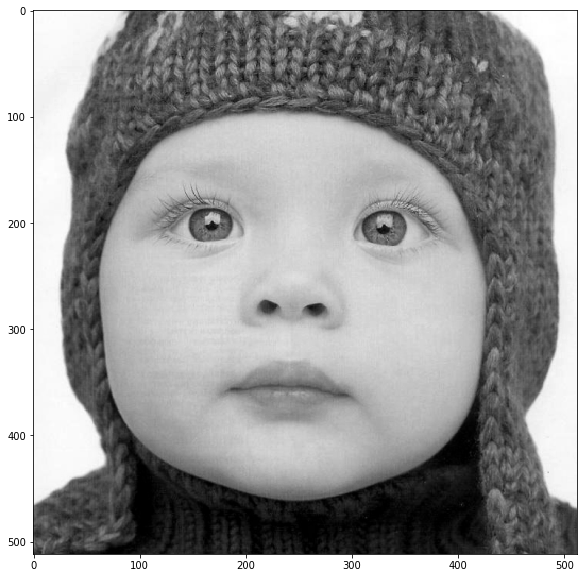

In [42]:
plt.figure(figsize=[10,10])
plt.imshow(fullimage[0,:,:,0], cmap='gray')

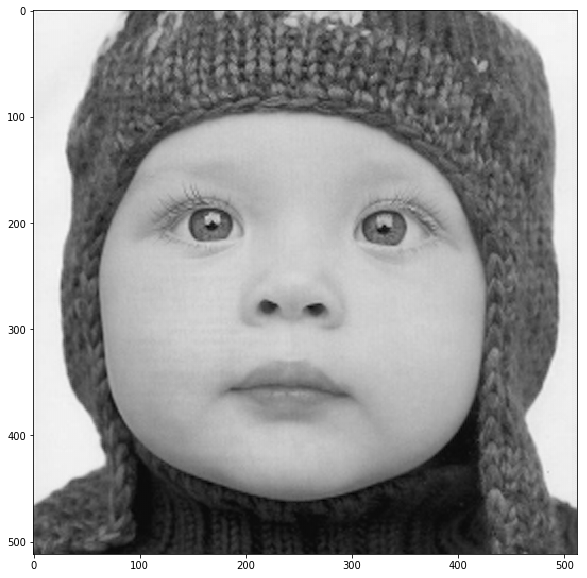

In [43]:
plt.figure(figsize=[10,10])
plt.imshow(outimage[0,:,:,0], cmap='gray')

In [44]:
20*np.log10(1./(np.sqrt(np.mean(np.square(outimage-fullimage)))))

35.69221397400337

In [45]:
SRImg = sess.run(model.SRImg, feed_dict={model.LRImg:LRImg})
SRImg.shape

(16, 32, 32, 1)

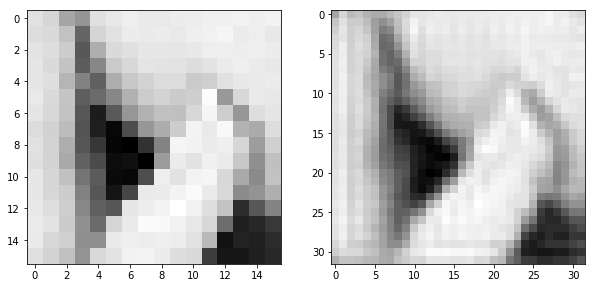

In [37]:
plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(LRImg[4,:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(SRImg[4,:,:,0], cmap='gray')

In [ ]:
self.conv1 = slim.conv2d(inputs=img, num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn=None, padding='SAME',
                                weights_initializer=tf.contrib.layers.xavier_initializer(), scope= 'conv1', reuse=tf.AUTO_REUSE)    
        
        
        
        self.RB1 = self.RB(self.conv1, 'rb1')
        self.RB2 = self.RB(self.RB1, 'rb2')
        self.RB3 = self.RB(self.RB2, 'rb3')
        self.RB4 = self.RB(self.RB3, 'rb4')
        self.RB5 = self.RB(self.RB4, 'rb5')
        self.RB6 = self.RB(self.RB5, 'rb6')
        self.RB7 = self.RB(self.RB6, 'rb7')
        self.RB8 = self.RB(self.RB7, 'rb8')
        self.RB9 = self.RB(self.RB8, 'rb9')
        self.RB10 = self.RB(self.RB9, 'rb10')
        self.RB11 = self.RB(self.RB10, 'rb11')
        self.RB12 = self.RB(self.RB11, 'rb12')
        self.RB13 = self.RB(self.RB12, 'rb13')
        self.RB14 = self.RB(self.RB13, 'rb14')
        self.RB15 = self.RB(self.RB14, 'rb15')
        self.RB16 = self.RB(self.RB15, 'rb16')
        
        with slim.arg_scope([slim.conv2d], kernel_size=[3,3], stride=[1,1], activation_fn=None, padding='SAME', 
                           weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            self.conv2 = slim.conv2d(inputs=self.RB16, num_outputs=64, scope='conv2')
            self.residual = tf.add(self.conv1, self.conv1, name='residual')
            self.conv3 = slim.conv2d(inputs=self.residual, num_outputs=4, scope='conv3')
        
            self.ps = PS(self.conv3, 2, False)
            self.conv4 = slim.conv2d(inputs=self.ps, num_outputs=1, scope='conv4')
        
        out = self.conv4
        self.out_layer = out


In [ ]:
name='cvlab'
        self.conv1 = slim.conv2d(inputs=img, num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn=None, padding='SAME',
                                weights_initializer=tf.contrib.layers.xavier_initializer(), scope= 'conv1', reuse=tf.AUTO_REUSE)    
        with slim.arg_scope([slim.conv2d], num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn = tf.nn.relu, padding='SAME',
                                                   weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            self.layer1 = slim.conv2d(inputs=self.conv1, scope='1conv1')
            self.layer2 = slim.conv2d(inputs=self.layer1, activation_fn=None, scope=name+'1conv2')
            self.layer3 = tf.add(self.layer2, self.conv1, name=name+'1residual')
            
            self.layer21 = slim.conv2d(inputs=self.layer3, scope='2convtg1')
            self.layer22 = slim.conv2d(inputs=self.layer21, activation_fn=None, scope=name+'2conv2')
            self.layer23 = tf.add(self.layer22, self.layer3, name=name+'2residual')
        
            self.layer31 = slim.conv2d(inputs=self.layer23, scope='32conv1')
            self.layer32 = slim.conv2d(inputs=self.layer31, activation_fn=None, scope=name+'32conv2')
            self.layer33 = tf.add(self.layer32, self.layer23, name=name+'32residual')
            
            self.layer41 = slim.conv2d(inputs=self.layer33, scope='42conv1')
            self.layer42 = slim.conv2d(inputs=self.layer41, activation_fn=None, scope=name+'42conv2')
            self.layer43 = tf.add(self.layer42, self.layer33, name=name+'42residual')
            
            self.layer51 = slim.conv2d(inputs=self.layer43, scope='52conv1')
            self.layer52 = slim.conv2d(inputs=self.layer51, activation_fn=None, scope=name+'52conv2')
            self.layer53 = tf.add(self.layer52, self.layer43, name=name+'52residual')
            
            self.layer61 = slim.conv2d(inputs=self.layer53, scope='62conv1')
            self.layer62 = slim.conv2d(inputs=self.layer61, activation_fn=None, scope=name+'62conv2')
            self.layer63 = tf.add(self.layer62, self.layer53, name=name+'62residual')
            
            self.layer71 = slim.conv2d(inputs=self.layer63, scope='72conv1')
            self.layer72 = slim.conv2d(inputs=self.layer71, activation_fn=None, scope=name+'72conv2')
            self.layer73 = tf.add(self.layer72, self.layer63, name=name+'72residual')
            
            self.layer81 = slim.conv2d(inputs=self.layer73, scope='82conv1')
            self.layer82 = slim.conv2d(inputs=self.layer81, activation_fn=None, scope=name+'82conv2')
            self.layer83 = tf.add(self.layer82, self.layer73, name=name+'82residual')
            
            self.layer91 = slim.conv2d(inputs=self.layer83, scope='92conv1')
            self.layer92 = slim.conv2d(inputs=self.layer91, activation_fn=None, scope=name+'92conv2')
            self.layer93 = tf.add(self.layer92, self.layer83, name=name+'92residual')
            
            self.layer101 = slim.conv2d(inputs=self.layer93, scope='102conv1')
            self.layer102 = slim.conv2d(inputs=self.layer101, activation_fn=None, scope=name+'102conv2')
            self.layer103 = tf.add(self.layer102, self.layer93, name=name+'102residual')
            
            self.layer111 = slim.conv2d(inputs=self.layer103, scope='112conv1')
            self.layer112 = slim.conv2d(inputs=self.layer111, activation_fn=None, scope=name+'112conv2')
            self.layer113 = tf.add(self.layer112, self.layer103, name=name+'112residual')
            
            self.layer121 = slim.conv2d(inputs=self.layer113, scope='122conv1')
            self.layer122 = slim.conv2d(inputs=self.layer121, activation_fn=None, scope=name+'122conv2')
            self.layer123 = tf.add(self.layer122, self.layer113, name=name+'212residual')
            
            self.layer131 = slim.conv2d(inputs=self.layer123, scope='132conv1')
            self.layer132 = slim.conv2d(inputs=self.layer131, activation_fn=None, scope=name+'132conv2')
            self.layer133 = tf.add(self.layer132, self.layer123, name=name+'132residual')
            
            self.layer141 = slim.conv2d(inputs=self.layer133, scope='2conv1')
            self.layer142 = slim.conv2d(inputs=self.layer141, activation_fn=None, scope=name+'142conv2')
            self.layer143 = tf.add(self.layer142, self.layer133, name=name+'142residual')
            
            self.layer151 = slim.conv2d(inputs=self.layer143, scope='152conv1')
            self.layer152 = slim.conv2d(inputs=self.layer151, activation_fn=None, scope=name+'152conv2')
            self.layer153 = tf.add(self.layer152, self.layer143, name=name+'152residual')
            
            self.layer161 = slim.conv2d(inputs=self.layer153, scope='162conv1')
            self.layer162 = slim.conv2d(inputs=self.layer161, activation_fn=None, scope=name+'162conv2')
            self.layer163 = tf.add(self.layer162, self.layer153, name=name+'216residual')
            
        with slim.arg_scope([slim.conv2d], kernel_size=[3,3], stride=[1,1], activation_fn=None, padding='SAME', 
                           weights_initializer=tf.contrib.layers.xavier_initializer(), reuse=tf.AUTO_REUSE):
            self.conv2 = slim.conv2d(inputs=self.layer163, num_outputs=64, scope='conv2')
            self.residual = tf.add(self.conv1, self.conv1, name='residual')
            self.conv3 = slim.conv2d(inputs=self.residual, num_outputs=4, scope='conv3')
        
            self.ps = PS(self.conv3, 2, False)
            self.conv4 = slim.conv2d(inputs=self.ps, num_outputs=1, scope='conv4')
        
        out = self.conv4
        self.out_layer = out

    